<a href="https://colab.research.google.com/github/lblum95/AML/blob/master/task1/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [284]:
#############################  new branch #####################################
###### SCORE TO BEAT 0.74
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/AML
!git branch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/AML
  master
* yb-t1


In [171]:
%cd /content/drive/My Drive/Colab Notebooks/AML/task1
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

X_submit=pd.read_csv('data/X_test.csv')
X_learnR=pd.read_csv('data/X_train.csv',index_col='id')
Y_learn=pd.read_csv('data/y_train.csv',index_col='id')
## Replace NaN by mean of column
X_learnR=X_learnR.where(pd.notna(X_learnR), X_learnR.mean(), axis='columns')
X_learn=X_learnR.copy()

## Remove values which are greater than 4x the Std Dev
for col_n in X_learn:
  col =X_learn[col_n]
  thresh=col.mean()+(3.5*col.std())
  X_learn[col_n]=col.where(col<thresh,col.mean())

## Normalize data between [0,1]
X_learn=pd.DataFrame(pp.MinMaxScaler().fit_transform(X_learn))
## Remove empty columns := where mean is 0
X_learn=X_learn.loc[:,X_learn.mean()>0]

#Split into train and test
x_train,x_test,y_train,y_test=train_test_split(X_learn,Y_learn,test_size=0.2)

## Deterministic split
x_tr_id=x_train.index
x_te_id=x_test.index
#x_train2=X_learn.loc[x_t_id]

/content/drive/My Drive/Colab Notebooks/AML/task1


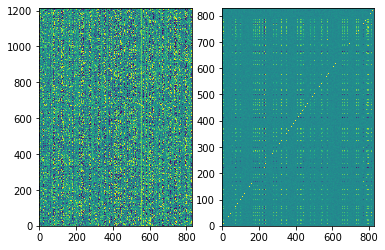

In [16]:
axes = plt.subplot2grid((1, 2), (0, 0))
plt.pcolor(X_learn)
cor = X_learn.corr()
axes = plt.subplot2grid((1, 2), (0, 1))
plt.pcolor(cor)

# 1. Basic linear Regression

In [77]:
reg = lm.LinearRegression().fit(x_train, y_train)
yh_train = reg.predict(x_train)
yh_test = reg.predict(x_test)
score_train = r2_score(yh_train, y_train)
score_test = r2_score(yh_test, y_test)
print("Training", score_train, "Test", score_test)

Training 0.9120009965986035 Test 0.026950178673703085


# Feature Selection

* PCA

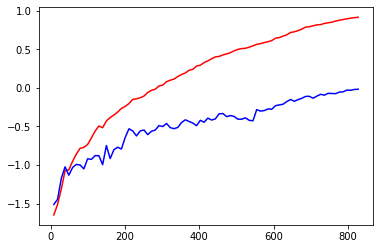

In [170]:
scoreTr=[]
scoreTe=[]
for i in range(8,828,40):
  pca = decomposition.PCA(n_components=i)
  pca.fit(X_learn)
  X = pca.transform(X_learn)
  X=pd.DataFrame(data=X,index=X_learn.index)
  x_trainFS=X.loc[x_tr_id]
  x_testFS=X.loc[x_te_id]
  reg = lm.LinearRegression().fit(x_trainFS, y_train)
  yh_train = reg.predict(x_trainFS)
  yh_test = reg.predict(x_testFS)
  scoreTr.append(r2_score(yh_train, y_train))
  scoreTe.append(r2_score(yh_test, y_test))
t = np.linspace(8,828,len(scoreTr))
plt.plot(t, scoreTr, 'r',label='Training Score')
plt.plot(t, scoreTe, 'b',label="Test Score")
plt.show()

* Selection based on pearson score

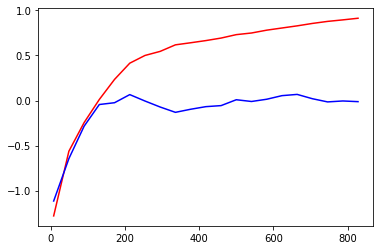

In [169]:
import warnings
warnings.filterwarnings('ignore')
scoreTr=[]
scoreTe=[]
for i in range(8,828,40):
  fs = SelectKBest(score_func=f_regression, k=i)
  fs.fit(x_train, y_train)
  x_testFS = fs.transform(x_test)
  x_trainFS = fs.transform(x_train)
  reg = lm.LinearRegression().fit(x_trainFS, y_train)
  yh_train = reg.predict(x_trainFS)
  yh_test = reg.predict(x_testFS)
  scoreTr.append(r2_score(yh_train, y_train))
  scoreTe.append(r2_score(yh_test, y_test))
t = np.linspace(8,828,len(scoreTr))
plt.plot(t, scoreTr, 'r',label='Training Score')
plt.plot(t, scoreTe, 'b',label="Test Score")
plt.show()

* Selection based on spearman score

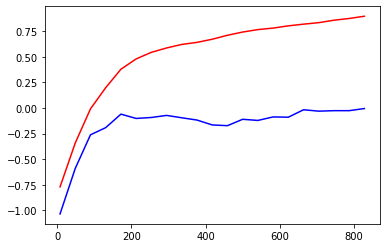

In [176]:
y=y_train.iloc[:,0]
corcoefs=[]
corname=[]
for i in range(828):
  x=x_train.iloc[:,i]
  corcoefs.append(abs(spearmanr(x,y)[0]))
  corname.append(x_train.iloc[:,i].name)
  #plt.scatter(x_train.iloc[:,1],y_train)
  #plt.show()
rank=pd.Series(data=corcoefs, index=corname)


scoreTr=[]
scoreTe=[]
for i in range(8,828,40):
  fs=rank.nlargest(i).index
  x_testFS = x_test.loc[:,fs]
  x_trainFS = x_train.loc[:,fs]
  reg = lm.LinearRegression().fit(x_trainFS, y_train)
  yh_train = reg.predict(x_trainFS)
  yh_test = reg.predict(x_testFS)
  scoreTr.append(r2_score(yh_train, y_train))
  scoreTe.append(r2_score(yh_test, y_test))
t = np.linspace(8,828,len(scoreTr))
plt.plot(t, scoreTr, 'r',label='Training Score')
plt.plot(t, scoreTe, 'b',label="Test Score")
plt.show()


* Greedy selection based on pearson score (meta overfit)

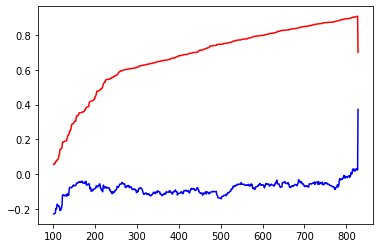

In [283]:
y=y_train.iloc[:,0]
corcoefs=[]
corname=[]
for i in range(828):
  x=x_train.iloc[:,i]
  corcoefs.append(abs(np.corrcoef(x,y)[0,1]))
  corname.append(x_train.iloc[:,i].name)
  #plt.scatter(x_train.iloc[:,1],y_train)
  #plt.show()
rank=pd.Series(data=corcoefs, index=corname)


goodF=np.ones(99).astype(bool)
scoreTr=[-5]
scoreTe=[-5]
keep=True
for i in range(100,828,1):
  fs=rank.nlargest(i).index
  fs=np.array(fs)
  #fs=fs[goodF]
  x_testFS = x_test.loc[:,fs]
  x_trainFS = x_train.loc[:,fs]
  reg = lm.LinearRegression().fit(x_trainFS, y_train)
  yh_train = reg.predict(x_trainFS)
  yh_test = reg.predict(x_testFS)
  scoreTr.append(r2_score(yh_train, y_train))
  scoreTe.append(r2_score(yh_test, y_test))
  goodF=np.append(goodF,True if scoreTe[-1]>scoreTe[-2] else False)


fs=rank.nlargest(i).index
fs=np.array(fs)
fs=fs[goodF]
x_testFS = x_test.loc[:,fs]
x_trainFS = x_train.loc[:,fs]
reg = lm.LinearRegression().fit(x_trainFS, y_train)
yh_train = reg.predict(x_trainFS)
yh_test = reg.predict(x_testFS)
scoreTr.append(r2_score(yh_train, y_train))
scoreTe.append(r2_score(yh_test, y_test))
t = np.linspace(100,828,len(scoreTr))
plt.plot(t[1:], scoreTr[1:], 'r',label='Training Score')
plt.plot(t[1:], scoreTe[1:], 'b',label="Test Score")
plt.show()


# 2. Lasso regression

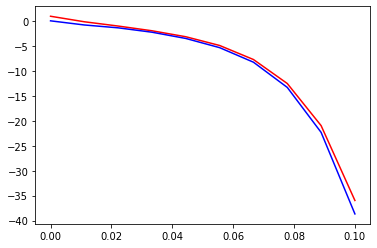

In [274]:
scoreTr=[]
scoreTe=[]
for i in np.linspace(0 ,0.5,10):
  reg = lm.Lasso(alpha=i)
  reg.fit(x_train, y_train)
  yh_train = reg.predict(x_train)
  yh_test = reg.predict(x_test)
  scoreTr.append(r2_score(yh_train, y_train))
  scoreTe.append(r2_score(yh_test, y_test))

t = np.linspace(0 ,0.1,10)
plt.plot(t, scoreTr, 'r',label='Training Score')
plt.plot(t, scoreTe, 'b',label="Test Score")
plt.show()

# 3. Ridge regression

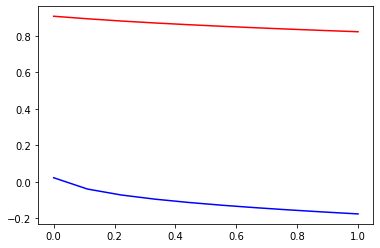

In [278]:
scoreTr=[]
scoreTe=[]
for i in np.linspace(0 ,1,10):
  reg = lm.Ridge(alpha=i)
  reg.fit(x_train, y_train)
  yh_train = reg.predict(x_train)
  yh_test = reg.predict(x_test)
  scoreTr.append(r2_score(yh_train, y_train))
  scoreTe.append(r2_score(yh_test, y_test))

t = np.linspace(0 ,1,10)
plt.plot(t, scoreTr, 'r',label='Training Score')
plt.plot(t, scoreTe, 'b',label="Test Score")
plt.show()

# 4. Random Forest

In [280]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100, random_state=0)
reg.fit(x_train, y_train)
yh_train = reg.predict(x_train)
yh_test = reg.predict(x_test)
score_train = r2_score(yh_train, y_train)
score_test = r2_score(yh_test, y_test)
print("Training", score_train, "Test", score_test)

Training 0.8914154170275576 Test -0.3408706268340107


# 5. Logistic Regression

In [282]:
reg= lm.LogisticRegression(random_state=0)
reg.fit(x_train, y_train)
yh_train = reg.predict(x_train)
yh_test = reg.predict(x_test)
score_train = r2_score(yh_train, y_train)
score_test = r2_score(yh_test, y_test)
print("Training", score_train, "Test", score_test)

Training 1.0 Test -2.842302744425386
